In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
from collections import Counter

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/poems-100.csv"


In [4]:
text = pd.read_csv(DATA_PATH, engine="python")

col = text.columns[0]
texts = text[col].dropna().astype(str).tolist()

print("Loaded poems:", len(texts))


Loaded poems: 100


In [5]:
def tokenize(text):
    return text.lower().split()

tokenized = [tokenize(t) for t in texts]

all_words = [word for line in tokenized for word in line]
vocab = sorted(set(all_words))

word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 6989


In [6]:
SEQ_LEN = 5

def make_sequences(token_list):
    X, y = [], []
    for line in token_list:
        if len(line) <= SEQ_LEN:
            continue
        for i in range(len(line)-SEQ_LEN):
            seq = line[i:i+SEQ_LEN]
            target = line[i+SEQ_LEN]

            X.append([word2idx[w] for w in seq])
            y.append(word2idx[target])
    return X, y

X, y = make_sequences(tokenized)

X = torch.tensor(X)
y = torch.tensor(y)

print("Total sequences:", len(X))

Total sequences: 24234


In [14]:
def one_hot_encode(batch, vocab_size):
    eye = torch.eye(vocab_size, device=batch.device)
    return eye[batch]


In [8]:
class OneHotRNN(nn.Module):
    def __init__(self, vocab_size, hidden):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [20]:
class OneHotLSTM(nn.Module):
    def __init__(self, vocab_size, hidden):
        super().__init__()

        self.lstm = nn.LSTM(vocab_size, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [9]:
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden, use_lstm=False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if use_lstm:
            self.rnn = nn.LSTM(embed_dim, hidden, batch_first=True)
        else:
            self.rnn = nn.RNN(embed_dim, hidden, batch_first=True)

        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)


In [16]:
def train_model(model, X, y, epochs=10, lr=0.001, onehot=False, batch_size=32):

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    n = len(X)

    for ep in range(epochs):

        model.train()
        total_loss = 0

        for i in range(0, n, batch_size):

            xb = X[i:i+batch_size].to(device)
            yb = y[i:i+batch_size].to(device)

            if onehot:
                inputs = one_hot_encode(xb, vocab_size)
            else:
                inputs = xb

            output = model(inputs)
            loss = criterion(output, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {ep+1} | Loss {total_loss:.4f}")

    return model


In [21]:
print("\nTraining One-Hot RNN\n")

onehot_model = OneHotRNN(vocab_size, hidden=128).to(device)
onehot_model = train_model(
    onehot_model,
    X, y,
    epochs=3,
    onehot=True,
    batch_size=16
)

print("\nTraining One-Hot LSTM\n")

onehot_lstm = OneHotLSTM(vocab_size, hidden=128).to(device)

onehot_lstm = train_model(
    onehot_lstm,
    X, y,
    epochs=3,
    onehot=True,
    batch_size=16
)

print("\nTraining Embedding RNN\n")

embed_rnn = EmbeddingModel(vocab_size, embed_dim=100, hidden=128, use_lstm=False).to(device)
embed_rnn = train_model(
    embed_rnn,
    X, y,
    epochs=15,
    batch_size=64
)

print("\nTraining Embedding LSTM\n")

embed_lstm = EmbeddingModel(vocab_size, embed_dim=100, hidden=128, use_lstm=True).to(device)
embed_lstm = train_model(
    embed_lstm,
    X, y,
    epochs=15,
    batch_size=64
)




Training One-Hot RNN

Epoch 1 | Loss 11039.4934
Epoch 2 | Loss 9521.0060
Epoch 3 | Loss 8565.2665

Training One-Hot LSTM

Epoch 1 | Loss 11095.9567
Epoch 2 | Loss 9647.1830
Epoch 3 | Loss 8906.5168

Training Embedding RNN

Epoch 1 | Loss 2818.3814
Epoch 2 | Loss 2416.3893
Epoch 3 | Loss 2241.2625
Epoch 4 | Loss 2097.2521
Epoch 5 | Loss 1953.2365
Epoch 6 | Loss 1798.6914
Epoch 7 | Loss 1652.1566
Epoch 8 | Loss 1518.0930
Epoch 9 | Loss 1394.3235
Epoch 10 | Loss 1256.8290
Epoch 11 | Loss 1124.2548
Epoch 12 | Loss 1011.4378
Epoch 13 | Loss 907.9819
Epoch 14 | Loss 812.0947
Epoch 15 | Loss 723.9549

Training Embedding LSTM

Epoch 1 | Loss 2811.7682
Epoch 2 | Loss 2498.5639
Epoch 3 | Loss 2334.2232
Epoch 4 | Loss 2180.8390
Epoch 5 | Loss 2021.0605
Epoch 6 | Loss 1862.2759
Epoch 7 | Loss 1680.8748
Epoch 8 | Loss 1508.2604
Epoch 9 | Loss 1356.9454
Epoch 10 | Loss 1224.0789
Epoch 11 | Loss 1104.3473
Epoch 12 | Loss 990.1151
Epoch 13 | Loss 881.0060
Epoch 14 | Loss 776.1196
Epoch 15 | Loss 677.

In [22]:
def generate(model, start_words, length=15, onehot=False):

    model.eval()
    words = start_words.lower().split()

    for _ in range(length):

        seq = [word2idx.get(w,0) for w in words[-SEQ_LEN:]]
        seq = torch.tensor(seq).unsqueeze(0).to(device)

        if onehot:
            seq = one_hot_encode(seq, vocab_size).to(device)

        with torch.no_grad():
            out = model(seq)
            pred = torch.argmax(out, dim=1).item()

        words.append(idx2word[pred])

    return " ".join(words)

In [24]:
print("OneHot RNN:")
print(generate(onehot_model, "the night is", onehot=True))

print("\nEmbedding RNN:")
print(generate(embed_rnn, "the night is"))

print("\nEmbedding LSTM:")
print(generate(embed_lstm, "the night is"))

OneHot RNN:
the night is of the continuous of the growth, of the couch of the ages of the ages

Embedding RNN:
the night is equally perfect, the sun shines now on a leaf, the trees playing celestial symphonies; i

Embedding LSTM:
the night is directed the behind he nodded “yes” to, and a heart was softened in the west,



Final Loss Comparison:

         Model  Final Loss
0   OneHot RNN     8565.26
1  OneHot LSTM     8906.51
2    Embed RNN      723.95
3   Embed LSTM      677.17


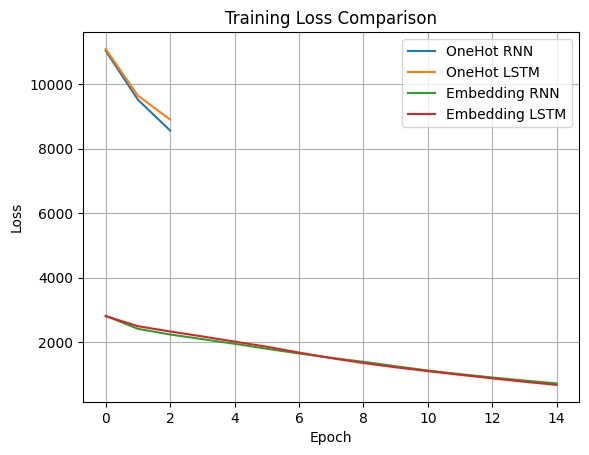

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

onehot_rnn = [11039.49, 9521.00, 8565.26]

onehot_lstm = [11095.95, 9647.18, 8906.51]

embed_rnn = [
2818.38,2416.38,2241.26,2097.25,1953.23,
1798.69,1652.15,1518.09,1394.32,1256.82,
1124.25,1011.43,907.98,812.09,723.95
]

embed_lstm = [
2811.76,2498.56,2334.22,2180.83,2021.06,
1862.27,1680.87,1508.26,1356.94,1224.07,
1104.34,990.11,881.00,776.11,677.17
]

data = {
    "Model": ["OneHot RNN", "OneHot LSTM", "Embed RNN", "Embed LSTM"],
    "Final Loss": [
        onehot_rnn[-1],
        onehot_lstm[-1],
        embed_rnn[-1],
        embed_lstm[-1]
    ]
}

df = pd.DataFrame(data)
print("\nFinal Loss Comparison:\n")
print(df)


plt.plot(onehot_rnn, label="OneHot RNN")
plt.plot(onehot_lstm, label="OneHot LSTM")
plt.plot(embed_rnn, label="Embedding RNN")
plt.plot(embed_lstm, label="Embedding LSTM")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()
